# Avalanche Prediction

## Setup

Install the required pacakges to run the script

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Data exploration

We started the project by looking at the data, trying to figure out which features to keep and which features not to keep.

## Dataset

Importing a dataset fetched from the Avalanche-Forecast-API and an external avalanche database.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('data/dataset.csv')


df.head(5)

,region,date,weekday,weekend,red_day,avalanche,DangerLevel,CloudCoverId,Nedbor,Vindstyrke,...,DestructiveSizeId_30,AvalTriggerSimpleId_30,AvalProbabilityId_45,AvalCauseId_45,DestructiveSizeId_45,AvalTriggerSimpleId_45,AvalProbabilityId_50,AvalCauseId_50,DestructiveSizeId_50,AvalTriggerSimpleId_50
0,3003,2017-12-01,5,0,0,0,1,20,2,Bris,...,0,0,0,0,0,0,0,0,0,0
1,3007,2017-12-01,5,0,0,0,2,30,2,Stiv kuling,...,2,21,0,0,0,0,0,0,0,0
2,3009,2017-12-01,5,0,0,0,2,30,3,Stiv kuling,...,2,21,0,0,0,0,0,0,0,0
3,3010,2017-12-01,5,0,0,0,2,30,7,Stiv kuling,...,2,21,0,0,0,0,0,0,0,0
4,3011,2017-12-01,5,0,0,0,2,30,6,Stiv kuling,...,2,21,0,0,0,0,0,0,0,0


## Create correlation plots for unprocessed data

In [3]:
from matplotlib import pyplot
import seaborn as sns

def create_correlation_plot(dataframe, filename):
    corr = dataframe.corr()
    sns.set(rc={'figure.figsize': (15.0, 15.0)})
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                              square=True, linewidths=.5, cbar_kws={"shrink": .5})
    figure = sns_heatmap.get_figure()
    figure.savefig(filename, dpi=200)
    pyplot.show()
    pyplot.clf()
    
dataframe = pd.read_csv("data/dataset.csv")

dataframe_without_problems = dataframe[['region', 'date', 'weekday', 'weekend', 'red_day', 'avalanche', 'DangerLevel', 'CloudCoverId', 'Nedbor', 'Vindstyrke', 'Temperatur_min', 'Temperatur_max']]

### Correlation plot for data without avalanche problems

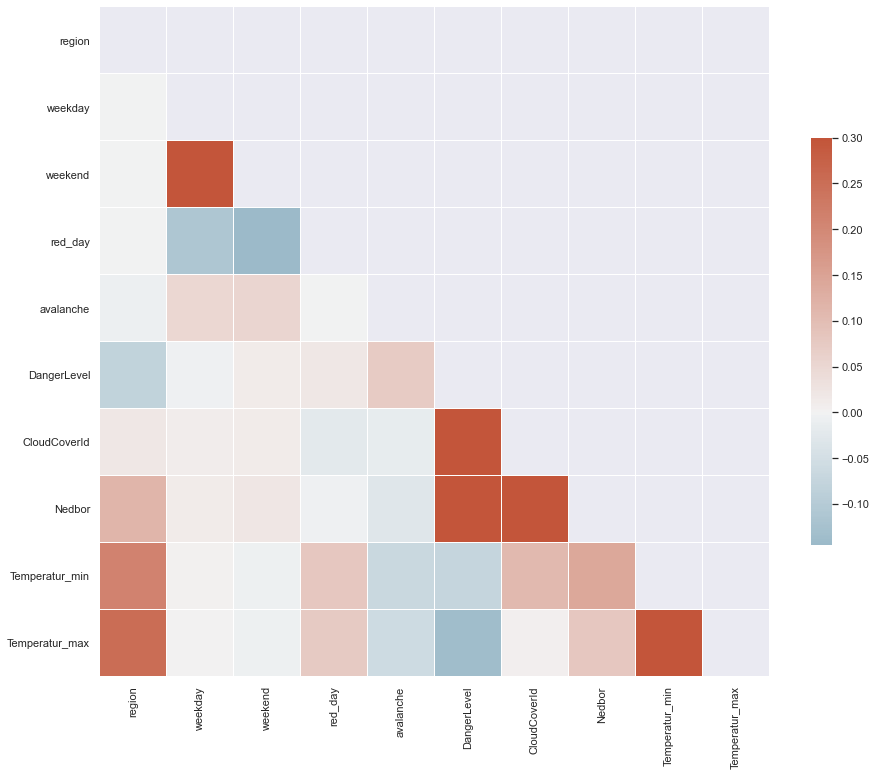

<Figure size 1080x1080 with 0 Axes>

In [4]:
create_correlation_plot(dataframe_without_problems, "plots/seaborn_heatmap_without_problems.png")

### Correlation plot for all data

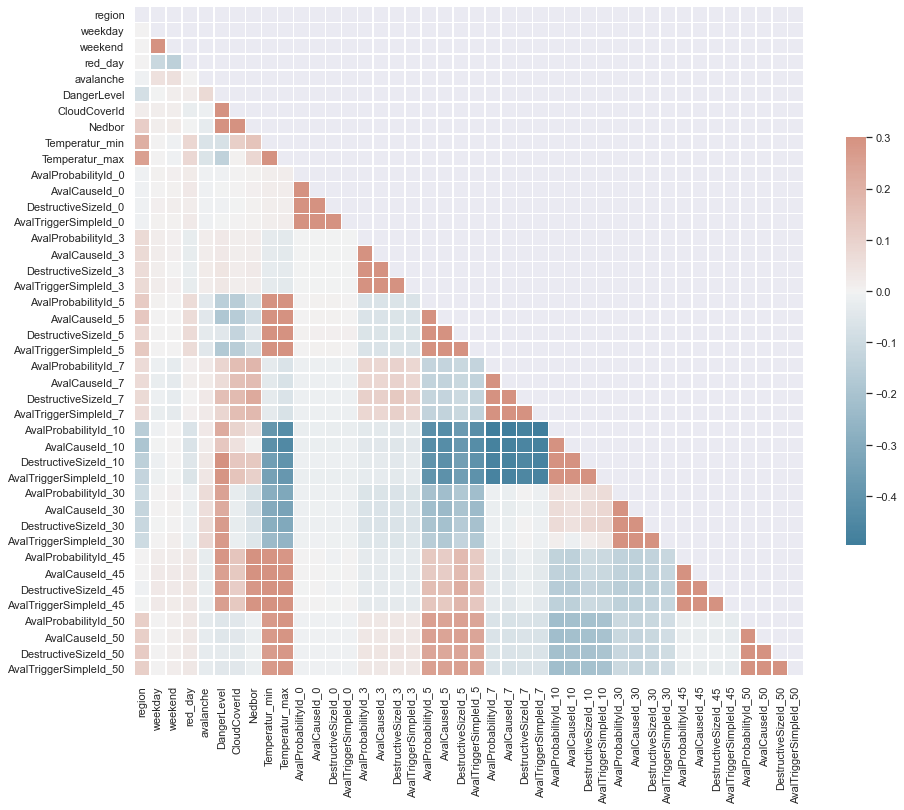

<Figure size 1080x1080 with 0 Axes>

In [5]:
create_correlation_plot(dataframe, "plots/seaborn_heatmap.png")

# Processing

### Convert date to month

The months are valued as intergers, where December startes at 0, and June ends at 6. 

The months included are Decemeber to June. 

In [6]:
dates = []

# Adds the dates in a list 'dates'.
for i in df.index:
    dates.append(df["date"][i])

# Makes the list into a set so it only is one of each of the dates.
set_date = set(dates)

# The date in the dataframe is changed with the month
for i in set_date:
    df["date"] = df["date"].replace(i, int(i[5:7]))

df["month"] = df["date"]
df["month"] = df["month"].replace(12, 0)


df[["date","month"]].head(5)

,date,month
0,12,0
1,12,0
2,12,0
3,12,0
4,12,0


### Change text to integer

In [7]:
df["Vindstyrke"].head(5)

0           Bris
1    Stiv kuling
2    Stiv kuling
3    Stiv kuling
4    Stiv kuling
Name: Vindstyrke, dtype: object

In [8]:
# Change the strings in "Vindstyrke" with numbers.

df["Vindstyrke"] = df["Vindstyrke"].replace("Stille/svak vind", 0)
df["Vindstyrke"] = df["Vindstyrke"].replace("Bris", 1)
df["Vindstyrke"] = df["Vindstyrke"].replace("Frisk bris", 2)
df["Vindstyrke"] = df["Vindstyrke"].replace("Liten kuling", 3)
df["Vindstyrke"] = df["Vindstyrke"].replace("Stiv kuling", 4)
df["Vindstyrke"] = df["Vindstyrke"].replace("Sterk kuling", 5)
df["Vindstyrke"] = df["Vindstyrke"].replace("Liten storm", 6)
df["Vindstyrke"] = df["Vindstyrke"].replace("Storm", 7)

df["Vindstyrke"].head(5)

0    1
1    4
2    4
3    4
4    4
Name: Vindstyrke, dtype: object

### Create mean value for temperature

In [9]:
# New columns with average temperature
temp_mean = df.loc[:, ["Temperatur_min", "Temperatur_max"]]
df['Temperatur_mean'] = temp_mean.mean(axis=1)

df[["Temperatur_min","Temperatur_max",'Temperatur_mean']].head(5)

,Temperatur_min,Temperatur_max,Temperatur_mean
0,-14,-9.0,-11.5
1,-10,-3.0,-6.5
2,-15,-4.0,-9.5
3,-10,-3.0,-6.5
4,-6,1.0,-2.5


### Binary encode category of month

In [10]:
# Binary encode month-category
month_1 = []
month_2 = []
month_3 = []

for ind in df.index:
    binary = bin(df["month"][ind]).format(3)

    if df["month"][ind] == 0:
        binary = "000"
    if df["month"][ind] == 1:
        binary = "001"
    if df["month"][ind] == 2:
        binary = "010"
    if df["month"][ind] == 3:
        binary = "011"
    month_1.append(binary[-3])
    month_2.append(binary[-2])
    month_3.append(binary[-1])

df["month_1"] = month_1
df["month_2"] = month_2
df["month_3"] = month_3

df[["month", "month_1","month_2","month_3"]].head(5)

,month,month_1,month_2,month_3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


### Create day_off feature

In [11]:
# Add day_off of weekend or red_day
day_off = []
for ind in df.index:
    if df["weekend"][ind] == 1 or df["red_day"][ind] == 1:
        day_off.append(1)
    else:
        day_off.append(0)
df["day_off"] = day_off


df[["weekend", "red_day", "day_off"]].head(5)

,weekend,red_day,day_off
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## Normalization

In [12]:
data_list = []

# Loops through the dataframe and the values is appended in a list of lists. Every list is a row.
for ind in df.index:
    data_list.append(
        [df["month_1"][ind],
         df["month_2"][ind],
         df["month_3"][ind],
         df["day_off"][ind],
         df["avalanche"][ind],
         df["DangerLevel"][ind],
         df["Nedbor"][ind],
         df["Vindstyrke"][ind],
         df["Temperatur_mean"][ind],
         df["AvalProbabilityId_0"][ind],
         df["AvalProbabilityId_3"][ind],
         df["AvalProbabilityId_5"][ind],
         df["AvalProbabilityId_7"][ind],
         df["AvalProbabilityId_10"][ind],
         df["AvalProbabilityId_30"][ind],
         df["AvalProbabilityId_45"][ind],
         df["AvalProbabilityId_50"][ind]])
    
# Process the list with data to values between 0-1
scaler = MinMaxScaler()
scaler.fit(data_list)
processed_data = scaler.transform(data_list)

# Makes the processed data to a dataframe
df_processed_data = pd.DataFrame(processed_data)

df_processed_data.columns = ['month_1', 'month_2', 'month_3',
                             'day_off', 'avalanche', 'danger_level', 'nedbor',
                             'vind_styrke', 'temperatur_mean', 'aval_probability_id_0',
                             'aval_probability_id_3', 'aval_probability_id_5',
                             'aval_probability_id_7', 'aval_probability_id_10',
                             'aval_probability_id_30', 'aval_probability_id_45',
                             'aval_probability_id_50']

# Makes a csv file of the processed data
df_processed_data.to_csv("data/processed_data.csv", index=False)

df_processed_data.head(5)

,month_1,month_2,month_3,day_off,avalanche,danger_level,nedbor,vind_styrke,temperatur_mean,aval_probability_id_0,aval_probability_id_3,aval_probability_id_5,aval_probability_id_7,aval_probability_id_10,aval_probability_id_30,aval_probability_id_45,aval_probability_id_50
0,0.0,0.0,0.0,0.0,0.0,0.25,0.022222,0.142857,0.436170,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.50,0.022222,0.571429,0.542553,0.0,0.0,0.0,0.0,0.6,0.6,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.50,0.033333,0.571429,0.478723,0.0,0.0,0.0,0.0,0.6,0.6,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.50,0.077778,0.571429,0.542553,0.0,0.0,0.0,0.0,0.6,0.6,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.50,0.066667,0.571429,0.627660,0.0,0.0,0.0,0.0,0.6,0.6,0.0,0.0


## Correlation plot for normalized dataset

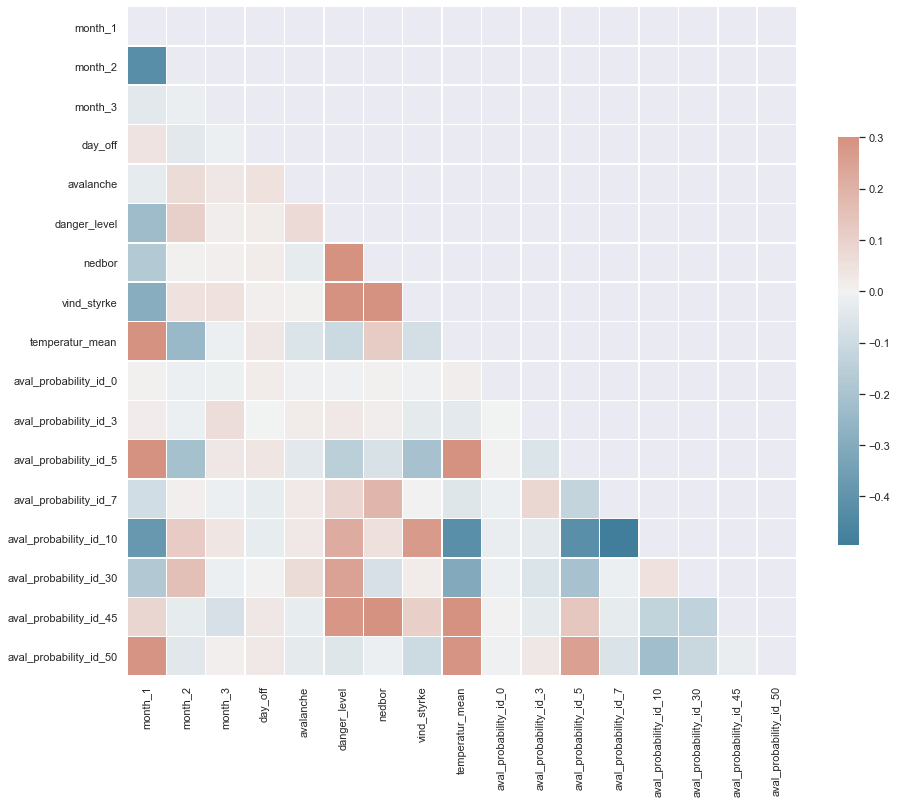

<Figure size 1080x1080 with 0 Axes>

In [13]:
create_correlation_plot(df_processed_data, "plots/seaborn_heatmap_processed_data.png")

# Balance dataset

In [14]:
df = pd.read_csv("data/processed_data.csv")

# Get rows with an avalanche

avalanches = df.loc[df["avalanche"] == 1]
not_avalanches = df.loc[df["avalanche"] == 0]

number_of_avalanches = len(avalanches.index)
number_of_not_avalanches = len(not_avalanches.index)

print("Number of days with avalanches:", number_of_avalanches)
print("Number of days without avalanches:", number_of_not_avalanches)
print("Ratio of days with avalanches:", number_of_avalanches / len(not_avalanches))
print()

print("Sampling {} rows with no avalanches".format(number_of_avalanches))
sample_of_not_avalanches = not_avalanches.sample(n=number_of_avalanches)

new_dataset = pd.concat([avalanches, sample_of_not_avalanches])

filename = "data/balanced_dataset.csv"

new_dataset.to_csv(filename, index=False)
print("Wrote {} rows to {}".format(len(new_dataset.index), filename))

Number of days with avalanches: 514
Number of days without avalanches: 11726
Ratio of days with avalanches: 0.04383421456592188

Sampling 514 rows with no avalanches
Wrote 1028 rows to data/balanced_dataset.csv


# Create and train model

The model is made using TensorFlow keras, and is a fully connected neural network consisting of 2 hidden layers (with 25 nodes each) and a softmax-layer with two output nodes at the end. By doing this, we have about the same amount of parameters in the model as there are training examples.

Adam is used as the optimizer.

In [15]:
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Read and shuffle dataset
print("Reading and shuffeling dataset")
df = pd.read_csv("data/balanced_dataset.csv").sample(frac=1)

# Initialize hyperparameters
HIDDEN_LAYER_SIZE = 25
OUTPUT_NODES = 2

# Start timer (for measuring total running time)
start_time = time.time()

# Split data into train set, test set and validation set
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, validation_df = train_test_split(train_df, test_size=0.1)

# Convert training-, test- and validation-data to numpy arrays of correct form
x_training_data = train_df.loc[:, train_df.columns != "avalanche"].to_numpy()
y_training_data = np.array([(x, abs(x - 1)) for x in train_df["avalanche"]])

x_testing_data = test_df.loc[:, test_df.columns != "avalanche"].to_numpy()
y_testing_data = np.array([(x, abs(x - 1)) for x in test_df["avalanche"]])

x_validation_data = validation_df.loc[:, validation_df.columns != "avalanche"].to_numpy()
y_validation_data = np.array([(x, abs(x - 1)) for x in validation_df["avalanche"]])

# Create the model
model = tf.keras.Sequential([
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation='relu'),  # 1st hidden layer
    tf.keras.layers.Dense(HIDDEN_LAYER_SIZE, activation='relu'),  # 2nd hidden layer
    # The final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(OUTPUT_NODES, activation='softmax')  # Output layer
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Loss function is chosen to consider the target output 0/1 as one-hot encoding.
batch_size = 100
max_epochs = 100

# Set an early stopping mechanism
# Let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4)

# Fit the model
# Note that this time the train, validation and test data are not iterable
model.fit(x_training_data,  # Train inputs
          y_training_data,  # Train targets
          batch_size=batch_size,  # Batch size
          epochs=max_epochs,  # Epochs that we will train for (assuming early stopping doesn't kick in)

          # Callbacks are functions called by a task when a task is completed
          # Task here is to check if val_loss is increasing
          callbacks=[early_stopping],  # Early stopping
          validation_data=(x_validation_data, y_validation_data),  # Validation data
          verbose=2  # Making sure we get enough information about the training process
          )

# Print how the model looks
print(model.summary())

# Test the model on test set
results = model.evaluate(x_testing_data, y_testing_data)
print('test loss, test acc:', results)

# Print total running time
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed_time: " + str(round(elapsed_time, 2)) + " seconds")

# Save model
model_filename = "resources/model.tf"
print("Saving model to", model_filename)
model.save(model_filename)

Reading and shuffeling dataset
Epoch 1/100
8/8 - 0s - loss: 0.7236 - accuracy: 0.5074 - val_loss: 0.7232 - val_accuracy: 0.4458
Epoch 2/100
8/8 - 0s - loss: 0.6926 - accuracy: 0.5386 - val_loss: 0.6958 - val_accuracy: 0.5542
Epoch 3/100
8/8 - 0s - loss: 0.6817 - accuracy: 0.5575 - val_loss: 0.6805 - val_accuracy: 0.5783
Epoch 4/100
8/8 - 0s - loss: 0.6753 - accuracy: 0.5913 - val_loss: 0.6723 - val_accuracy: 0.5663
Epoch 5/100
8/8 - 0s - loss: 0.6704 - accuracy: 0.5913 - val_loss: 0.6671 - val_accuracy: 0.5783
Epoch 6/100
8/8 - 0s - loss: 0.6666 - accuracy: 0.5940 - val_loss: 0.6629 - val_accuracy: 0.5904
Epoch 7/100
8/8 - 0s - loss: 0.6628 - accuracy: 0.5968 - val_loss: 0.6610 - val_accuracy: 0.6145
Epoch 8/100
8/8 - 0s - loss: 0.6596 - accuracy: 0.5981 - val_loss: 0.6553 - val_accuracy: 0.6145
Epoch 9/100
8/8 - 0s - loss: 0.6558 - accuracy: 0.6022 - val_loss: 0.6527 - val_accuracy: 0.6506
Epoch 10/100
8/8 - 0s - loss: 0.6532 - accuracy: 0.6049 - val_loss: 0.6504 - val_accuracy: 0.638

# Visualization

It is important to note that the data which is visualized is included in the data used for training. Some might say this is not optimal.

## Create map

In [17]:
import json
from shapely.geometry import shape
import matplotlib.pyplot as plt
from colour import Color
from tensorflow import keras

region_name_dict = {
    3003: "Nordenskiöld Land",
    3006: "Finnmarkskysten",
    3007: "Vest-Finnmark",
    3009: "Nord-Troms",
    3010: "Lyngen",
    3011: "Tromsø",
    3012: "Sør-Troms",
    3013: "Indre Troms",
    3014: "Lofoten og Vesterålen",
    3015: "Ofoten",
    3016: "Salten",
    3017: "Svartisen",
    3022: "Trollheimen",
    3023: "Romsdal",
    3024: "Sunnmøre",
    3027: "Indre Fjordane",
    3028: "Jotunheimen",
    3029: "Indre Sogn",
    3031: "Voss",
    3032: "Hallingdal",
    3034: "Hardanger",
    3035: "Vest-Telemark",
    3037: "Heiane",
    3001: "Svalbard øst",
    3002: "Svalbard vest",
    3004: "Svalbard sør",
    3005: "Øst-Finnmark",
    3008: "Finnmarksvidda",
    3018: "Helgeland",
    3019: "Nord-Trøndelag",
    3020: "Sør-Trøndelag",
    3021: "Ytre Nordmøre",
    3025: "Nord-Gudbrandsdalen",
    3026: "Ytre Fjordane",
    3030: "Ytre Sogn",
    3033: "Hordalandskysten",
    3036: "Rogalandskysten",
    3038: "Agder sør",
    3039: "Telemark sør",
    3040: "Vestfold",
    3041: "Buskerud sør",
    3042: "Oppland sør",
    3043: "Hedmark",
    3044: "Akershus",
    3045: "Oslo",
    3046: "Østfold"
}

In [18]:
def create_map(forecast_map, number_of_values):
    """Creates a map plot containing all avalanche regions with a redness
    scale representing danger.

    Input is a dictionary containing region_ids as keys and
    danger_values as values. If there are some regions that are not
    presented in the dictionary, these will have the lowest
    danger_value (white).

    Args:
        forecaset_map (dict[int, int]): Dictionary with values of the form {forecast_region_id: danger_value}
        number_of_values (int): The maximum possible value for danger_value in the dictionary
    """

    with open('resources/forecast_areas.json') as f:
        json_map_data = json.load(f)

    forecast_region_shapes = {}

    for feature in json_map_data['features']:
        forecast_region_shape = shape(feature['geometry'])
        forecast_region_id = feature["properties"]["omradeID"]
        forecast_region_shapes[forecast_region_id] = forecast_region_shape

    # Create color values
    start_color = Color("white")
    end_color = Color("red")
    colors = list(start_color.range_to(end_color, number_of_values))

    for region_id, region_shape in forecast_region_shapes.items():
        if (region_id in forecast_map):
            forecast = forecast_map[region_id]
            color = colors[forecast]
        else:
            color = colors[0]

        x, y = region_shape.exterior.xy

        # Fill region with correct color
        plt.fill(x, y, color.get_hex())

        # Print outline of region
        plt.plot(x, y, "k")

    plt.savefig("plots/map.png", dpi=300)
    print("Map plot saved to plot folder")

## Predictions for 1st of march 2020

Map plot saved to plot folder


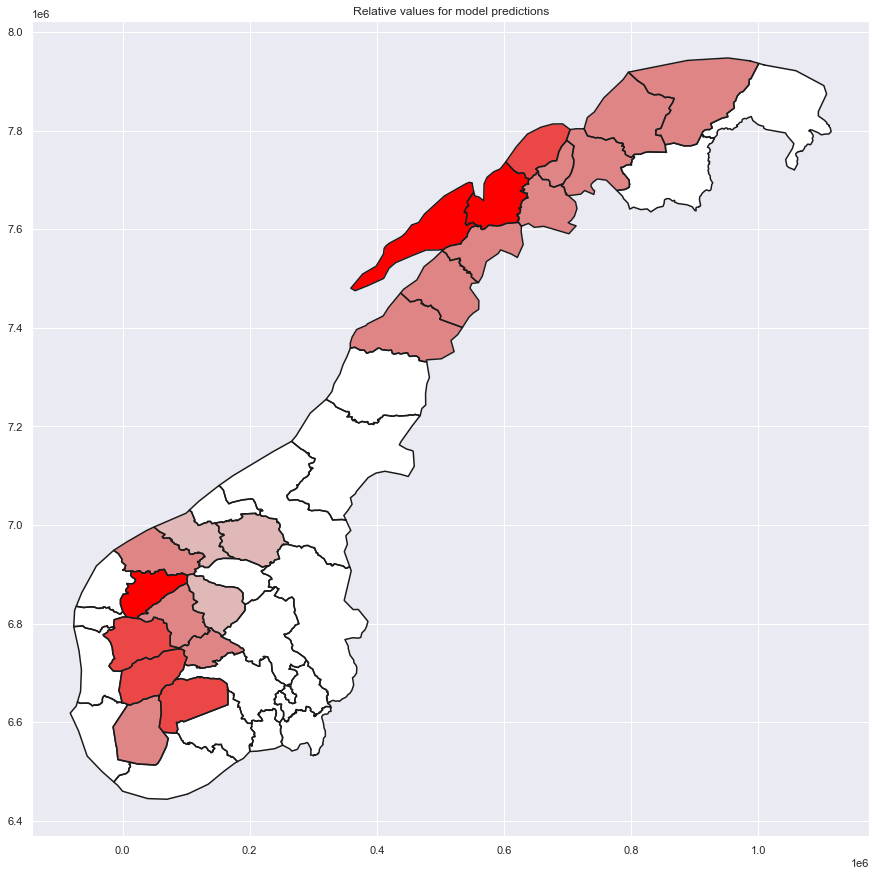

In [19]:
dummy_df = pd.read_csv("resources/input_mock_data_1_of_march.csv")

region_data_df = dummy_df.copy()
region_data_df.drop("avalanche", axis=1, inplace=True)
region_data_df.drop("region", axis=1, inplace=True)
region_data_list = list(region_data_df.to_numpy())

for i in range(len(region_data_list)):
    region_data_list[i] = [float(value) for value in region_data_list[i]]

model = keras.models.load_model('resources/model.tf')
model_predictions = []
for region_data in region_data_list:
    prediction = model.predict([region_data])[0][0]
    model_predictions.append(round(prediction, 2))

region_ids = dummy_df["region"]

# Create map plot
percentage_model_predictions = [int(prediction * 100) for prediction in model_predictions]
lowest_value = min(percentage_model_predictions)
highest_value = max(percentage_model_predictions)

number_of_values = highest_value - lowest_value
relative_predictions = [x - lowest_value for x in percentage_model_predictions]
forecast_map = dict(zip(region_ids, relative_predictions))

plt.title("Relative values for model predictions")

create_map(forecast_map, number_of_values + 1)

In [20]:
# Create dataframe containing model predictions for regions
region_name_list = []
for region_id in region_ids:
    region_name = region_name_dict[region_id]
    region_name_list.append(region_name)

df = pd.DataFrame({
    "region_id": region_ids,
    "region_name": region_name_list,
    "model_prediction": model_predictions
})

print("Predictions for regions for 1st of march:")
print(df)

Predictions for regions for 1st of march:
    region_id            region_name  model_prediction
0        3003      Nordenskiöld Land              0.72
1        3006        Finnmarkskysten              0.76
2        3007          Vest-Finnmark              0.76
3        3009             Nord-Troms              0.76
4        3010                 Lyngen              0.76
5        3011                 Tromsø              0.77
6        3012              Sør-Troms              0.78
7        3013            Indre Troms              0.75
8        3014  Lofoten og Vesterålen              0.78
9        3015                 Ofoten              0.76
10       3016                 Salten              0.76
11       3017              Svartisen              0.75
12       3022            Trollheimen              0.74
13       3023                Romsdal              0.74
14       3024               Sunnmøre              0.76
15       3027         Indre Fjordane              0.78
16       3028          

In [21]:
# Show the mock-data used for prediction of the plot above

dummy_df.head(23)

,region,month_1,month_2,month_3,day_off,avalanche,danger_level,nedbor,vind_styrke,temperatur_mean,aval_probability_id_0,aval_probability_id_3,aval_probability_id_5,aval_probability_id_7,aval_probability_id_10,aval_probability_id_30,aval_probability_id_45,aval_probability_id_50
0,3003,0.0,1.0,1.0,1.0,0.0,0.25,0.000000,0.142857,0.170213,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0
1,3006,0.0,1.0,1.0,1.0,0.0,0.50,0.000000,0.142857,0.436170,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
2,3007,0.0,1.0,1.0,1.0,0.0,0.50,0.000000,0.285714,0.457447,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
3,3009,0.0,1.0,1.0,1.0,0.0,0.50,0.000000,0.285714,0.414894,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
4,3010,0.0,1.0,1.0,1.0,0.0,0.50,0.055556,0.285714,0.457447,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0
5,3011,0.0,1.0,1.0,1.0,1.0,0.50,0.055556,0.142857,0.531915,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0
6,3012,0.0,1.0,1.0,1.0,0.0,0.75,0.055556,0.142857,0.510638,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
7,3013,0.0,1.0,1.0,1.0,1.0,0.50,0.011111,0.142857,0.404255,0.0,0.0,0.0,0.6,0.0,0.6,0.0,0.0
8,3014,0.0,1.0,1.0,1.0,0.0,0.75,0.055556,0.142857,0.531915,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
9,3015,0.0,1.0,1.0,1.0,0.0,0.50,0.011111,0.142857,0.404255,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0


## Predictions for 16th of january 2020

Map plot saved to plot folder


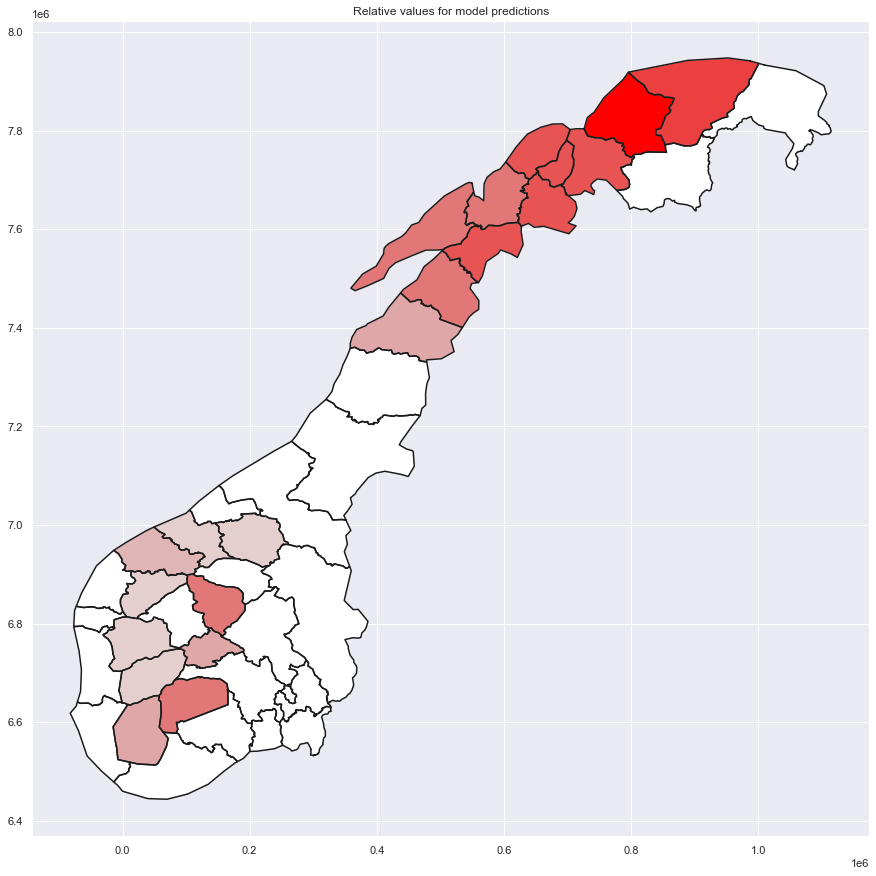

In [22]:
dummy_df = pd.read_csv("resources/input_mock_data_16_of_january.csv")

region_data_df = dummy_df.copy()
region_data_df.drop("avalanche", axis=1, inplace=True)
region_data_df.drop("region", axis=1, inplace=True)
region_data_list = list(region_data_df.to_numpy())

for i in range(len(region_data_list)):
    region_data_list[i] = [float(value) for value in region_data_list[i]]

model = keras.models.load_model('resources/model.tf')
model_predictions = []
for region_data in region_data_list:
    prediction = model.predict([region_data])[0][0]
    model_predictions.append(round(prediction, 2))

region_ids = dummy_df["region"]

# Create map plot
percentage_model_predictions = [int(prediction * 100) for prediction in model_predictions]
lowest_value = min(percentage_model_predictions)
highest_value = max(percentage_model_predictions)

number_of_values = highest_value - lowest_value
relative_predictions = [x - lowest_value for x in percentage_model_predictions]
forecast_map = dict(zip(region_ids, relative_predictions))

plt.title("Relative values for model predictions")

create_map(forecast_map, number_of_values + 1)

In [23]:
# Create dataframe containing model predictions for regions
region_name_list = []
for region_id in region_ids:
    region_name = region_name_dict[region_id]
    region_name_list.append(region_name)

df = pd.DataFrame({
    "region_id": region_ids,
    "region_name": region_name_list,
    "model_prediction": model_predictions
})

print("Predictions for regions for 1st of march:")
print(df)

Predictions for regions for 1st of march:
    region_id            region_name  model_prediction
0        3003      Nordenskiöld Land              0.41
1        3006        Finnmarkskysten              0.38
2        3007          Vest-Finnmark              0.40
3        3009             Nord-Troms              0.36
4        3010                 Lyngen              0.36
5        3011                 Tromsø              0.36
6        3012              Sør-Troms              0.35
7        3013            Indre Troms              0.36
8        3014  Lofoten og Vesterålen              0.34
9        3015                 Ofoten              0.36
10       3016                 Salten              0.35
11       3017              Svartisen              0.32
12       3022            Trollheimen              0.29
13       3023                Romsdal              0.29
14       3024               Sunnmøre              0.30
15       3027         Indre Fjordane              0.29
16       3028          

In [24]:
# Show the mock-data used for prediction of the plot above

dummy_df.head(23)

,region,month_1,month_2,month_3,day_off,avalanche,danger_level,nedbor,vind_styrke,temperatur_mean,aval_probability_id_0,aval_probability_id_3,aval_probability_id_5,aval_probability_id_7,aval_probability_id_10,aval_probability_id_30,aval_probability_id_45,aval_probability_id_50
0,3003,0.0,0.0,1.0,0.0,0.0,0.50,0.000000,0.142857,0.202128,0.0,0.0,0.0,0.0,0.6,0.6,0.0,0.0
1,3006,0.0,0.0,1.0,0.0,0.0,0.75,0.022222,0.285714,0.457447,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
2,3007,0.0,0.0,1.0,0.0,0.0,0.50,0.000000,0.285714,0.436170,0.0,0.0,0.0,0.0,0.6,0.6,0.0,0.0
3,3009,0.0,0.0,1.0,0.0,0.0,0.50,0.000000,0.285714,0.478723,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
4,3010,0.0,0.0,1.0,0.0,0.0,0.50,0.000000,0.285714,0.521277,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
5,3011,0.0,0.0,1.0,0.0,0.0,0.50,0.000000,0.285714,0.563830,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
6,3012,0.0,0.0,1.0,0.0,0.0,0.50,0.055556,0.285714,0.595745,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
7,3013,0.0,0.0,1.0,0.0,0.0,0.50,0.022222,0.285714,0.500000,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
8,3014,0.0,0.0,1.0,0.0,0.0,0.50,0.088889,0.285714,0.638298,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
9,3015,0.0,0.0,1.0,0.0,0.0,0.75,0.111111,0.285714,0.563830,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0


## Evaluation of model

### Test model

Run the model through the whole dataset to check the distribution of predicted values for cases where we had an avalanche and where we did not have an avalanche.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

model = keras.models.load_model('resources/model.tf')

df = pd.read_csv("data/balanced_dataset.csv")

rows = list(df.loc[:, df.columns != "avalanche"].to_numpy())

for i in range(len(rows)):
    rows[i] = [float(value) for value in rows[i]]

labels = df["avalanche"]

prediction_values_for_avalanche = []
prediction_values_for_not_avalanche = []

for i in range(len(rows)):
    prediction = model.predict([rows[i]])[0]

    # Round numbers
    prediction = [round(prediction[0], 2), round(prediction[1], 2)]
    prediction_value = prediction[0]

    print("True avalanche value: ", labels[i], "- prediction =", prediction, end="")

    failed_value = round(abs(labels[i] - prediction[0]), 2)

    print(", failed by", failed_value)

    if (labels[i] == 1.0):
        prediction_values_for_avalanche.append(prediction_value)
    else:
        prediction_values_for_not_avalanche.append(prediction_value)

mean_prediction_value_for_avalanche = sum(prediction_values_for_avalanche) / len(prediction_values_for_avalanche)
mean_prediction_value_for_not_avalanche = sum(prediction_values_for_not_avalanche) / len(prediction_values_for_not_avalanche)


True avalanche value:  1.0 - prediction = [0.41, 0.59], failed by 0.59
True avalanche value:  1.0 - prediction = [0.24, 0.76], failed by 0.76
True avalanche value:  1.0 - prediction = [0.38, 0.62], failed by 0.62
True avalanche value:  1.0 - prediction = [0.32, 0.68], failed by 0.68
True avalanche value:  1.0 - prediction = [0.52, 0.48], failed by 0.48
True avalanche value:  1.0 - prediction = [0.31, 0.69], failed by 0.69
True avalanche value:  1.0 - prediction = [0.47, 0.53], failed by 0.53
True avalanche value:  1.0 - prediction = [0.56, 0.44], failed by 0.44
True avalanche value:  1.0 - prediction = [0.48, 0.52], failed by 0.52
True avalanche value:  1.0 - prediction = [0.41, 0.59], failed by 0.59
True avalanche value:  1.0 - prediction = [0.42, 0.58], failed by 0.58
True avalanche value:  1.0 - prediction = [0.48, 0.52], failed by 0.52
True avalanche value:  1.0 - prediction = [0.4, 0.6], failed by 0.6
True avalanche value:  1.0 - prediction = [0.39, 0.61], failed by 0.61
True aval

True avalanche value:  1.0 - prediction = [0.8, 0.2], failed by 0.2
True avalanche value:  1.0 - prediction = [0.78, 0.22], failed by 0.22
True avalanche value:  1.0 - prediction = [0.79, 0.21], failed by 0.21
True avalanche value:  1.0 - prediction = [0.76, 0.24], failed by 0.24
True avalanche value:  1.0 - prediction = [0.8, 0.2], failed by 0.2
True avalanche value:  1.0 - prediction = [0.78, 0.22], failed by 0.22
True avalanche value:  1.0 - prediction = [0.76, 0.24], failed by 0.24
True avalanche value:  1.0 - prediction = [0.77, 0.23], failed by 0.23
True avalanche value:  1.0 - prediction = [0.73, 0.27], failed by 0.27
True avalanche value:  1.0 - prediction = [0.67, 0.33], failed by 0.33
True avalanche value:  1.0 - prediction = [0.67, 0.33], failed by 0.33
True avalanche value:  1.0 - prediction = [0.65, 0.35], failed by 0.35
True avalanche value:  1.0 - prediction = [0.56, 0.44], failed by 0.44
True avalanche value:  1.0 - prediction = [0.51, 0.49], failed by 0.49
True avalanc

True avalanche value:  1.0 - prediction = [0.63, 0.37], failed by 0.37
True avalanche value:  1.0 - prediction = [0.41, 0.59], failed by 0.59
True avalanche value:  1.0 - prediction = [0.54, 0.46], failed by 0.46
True avalanche value:  1.0 - prediction = [0.51, 0.49], failed by 0.49
True avalanche value:  1.0 - prediction = [0.52, 0.48], failed by 0.48
True avalanche value:  1.0 - prediction = [0.59, 0.41], failed by 0.41
True avalanche value:  1.0 - prediction = [0.49, 0.51], failed by 0.51
True avalanche value:  1.0 - prediction = [0.61, 0.39], failed by 0.39
True avalanche value:  1.0 - prediction = [0.76, 0.24], failed by 0.24
True avalanche value:  1.0 - prediction = [0.73, 0.27], failed by 0.27
True avalanche value:  1.0 - prediction = [0.67, 0.33], failed by 0.33
True avalanche value:  1.0 - prediction = [0.62, 0.38], failed by 0.38
True avalanche value:  1.0 - prediction = [0.58, 0.42], failed by 0.42
True avalanche value:  1.0 - prediction = [0.46, 0.54], failed by 0.54
True a

True avalanche value:  1.0 - prediction = [0.18, 0.82], failed by 0.82
True avalanche value:  1.0 - prediction = [0.56, 0.44], failed by 0.44
True avalanche value:  1.0 - prediction = [0.35, 0.65], failed by 0.65
True avalanche value:  1.0 - prediction = [0.63, 0.37], failed by 0.37
True avalanche value:  1.0 - prediction = [0.33, 0.67], failed by 0.67
True avalanche value:  1.0 - prediction = [0.37, 0.63], failed by 0.63
True avalanche value:  1.0 - prediction = [0.2, 0.8], failed by 0.8
True avalanche value:  1.0 - prediction = [0.62, 0.38], failed by 0.38
True avalanche value:  1.0 - prediction = [0.61, 0.39], failed by 0.39
True avalanche value:  1.0 - prediction = [0.58, 0.42], failed by 0.42
True avalanche value:  1.0 - prediction = [0.57, 0.43], failed by 0.43
True avalanche value:  1.0 - prediction = [0.33, 0.67], failed by 0.67
True avalanche value:  1.0 - prediction = [0.64, 0.36], failed by 0.36
True avalanche value:  1.0 - prediction = [0.61, 0.39], failed by 0.39
True aval

True avalanche value:  1.0 - prediction = [0.42, 0.58], failed by 0.58
True avalanche value:  1.0 - prediction = [0.3, 0.7], failed by 0.7
True avalanche value:  1.0 - prediction = [0.18, 0.82], failed by 0.82
True avalanche value:  1.0 - prediction = [0.21, 0.79], failed by 0.79
True avalanche value:  1.0 - prediction = [0.21, 0.79], failed by 0.79
True avalanche value:  1.0 - prediction = [0.6, 0.4], failed by 0.4
True avalanche value:  1.0 - prediction = [0.51, 0.49], failed by 0.49
True avalanche value:  1.0 - prediction = [0.49, 0.51], failed by 0.51
True avalanche value:  1.0 - prediction = [0.6, 0.4], failed by 0.4
True avalanche value:  1.0 - prediction = [0.43, 0.57], failed by 0.57
True avalanche value:  1.0 - prediction = [0.26, 0.74], failed by 0.74
True avalanche value:  1.0 - prediction = [0.34, 0.66], failed by 0.66
True avalanche value:  1.0 - prediction = [0.41, 0.59], failed by 0.59
True avalanche value:  1.0 - prediction = [0.68, 0.32], failed by 0.32
True avalanche 

True avalanche value:  0.0 - prediction = [0.26, 0.74], failed by 0.26
True avalanche value:  0.0 - prediction = [0.37, 0.63], failed by 0.37
True avalanche value:  0.0 - prediction = [0.79, 0.21], failed by 0.79
True avalanche value:  0.0 - prediction = [0.24, 0.76], failed by 0.24
True avalanche value:  0.0 - prediction = [0.22, 0.78], failed by 0.22
True avalanche value:  0.0 - prediction = [0.26, 0.74], failed by 0.26
True avalanche value:  0.0 - prediction = [0.36, 0.64], failed by 0.36
True avalanche value:  0.0 - prediction = [0.73, 0.27], failed by 0.73
True avalanche value:  0.0 - prediction = [0.26, 0.74], failed by 0.26
True avalanche value:  0.0 - prediction = [0.38, 0.62], failed by 0.38
True avalanche value:  0.0 - prediction = [0.27, 0.73], failed by 0.27
True avalanche value:  0.0 - prediction = [0.43, 0.57], failed by 0.43
True avalanche value:  0.0 - prediction = [0.48, 0.52], failed by 0.48
True avalanche value:  0.0 - prediction = [0.4, 0.6], failed by 0.4
True aval

True avalanche value:  0.0 - prediction = [0.41, 0.59], failed by 0.41
True avalanche value:  0.0 - prediction = [0.15, 0.85], failed by 0.15
True avalanche value:  0.0 - prediction = [0.49, 0.51], failed by 0.49
True avalanche value:  0.0 - prediction = [0.37, 0.63], failed by 0.37
True avalanche value:  0.0 - prediction = [0.38, 0.62], failed by 0.38
True avalanche value:  0.0 - prediction = [0.63, 0.37], failed by 0.63
True avalanche value:  0.0 - prediction = [0.29, 0.71], failed by 0.29
True avalanche value:  0.0 - prediction = [0.55, 0.45], failed by 0.55
True avalanche value:  0.0 - prediction = [0.5, 0.5], failed by 0.5
True avalanche value:  0.0 - prediction = [0.45, 0.55], failed by 0.45
True avalanche value:  0.0 - prediction = [0.72, 0.28], failed by 0.72
True avalanche value:  0.0 - prediction = [0.33, 0.67], failed by 0.33
True avalanche value:  0.0 - prediction = [0.43, 0.57], failed by 0.43
True avalanche value:  0.0 - prediction = [0.26, 0.74], failed by 0.26
True aval

True avalanche value:  0.0 - prediction = [0.47, 0.53], failed by 0.47
True avalanche value:  0.0 - prediction = [0.62, 0.38], failed by 0.62
True avalanche value:  0.0 - prediction = [0.64, 0.36], failed by 0.64
True avalanche value:  0.0 - prediction = [0.65, 0.35], failed by 0.65
True avalanche value:  0.0 - prediction = [0.37, 0.63], failed by 0.37
True avalanche value:  0.0 - prediction = [0.64, 0.36], failed by 0.64
True avalanche value:  0.0 - prediction = [0.57, 0.43], failed by 0.57
True avalanche value:  0.0 - prediction = [0.25, 0.75], failed by 0.25
True avalanche value:  0.0 - prediction = [0.26, 0.74], failed by 0.26
True avalanche value:  0.0 - prediction = [0.27, 0.73], failed by 0.27
True avalanche value:  0.0 - prediction = [0.35, 0.65], failed by 0.35
True avalanche value:  0.0 - prediction = [0.08, 0.92], failed by 0.08
True avalanche value:  0.0 - prediction = [0.74, 0.26], failed by 0.74
True avalanche value:  0.0 - prediction = [0.69, 0.31], failed by 0.69
True a

True avalanche value:  0.0 - prediction = [0.45, 0.55], failed by 0.45
True avalanche value:  0.0 - prediction = [0.44, 0.56], failed by 0.44
True avalanche value:  0.0 - prediction = [0.61, 0.39], failed by 0.61
True avalanche value:  0.0 - prediction = [0.2, 0.8], failed by 0.2
True avalanche value:  0.0 - prediction = [0.23, 0.77], failed by 0.23
True avalanche value:  0.0 - prediction = [0.47, 0.53], failed by 0.47
True avalanche value:  0.0 - prediction = [0.65, 0.35], failed by 0.65
True avalanche value:  0.0 - prediction = [0.6, 0.4], failed by 0.6
True avalanche value:  0.0 - prediction = [0.33, 0.67], failed by 0.33
True avalanche value:  0.0 - prediction = [0.3, 0.7], failed by 0.3
True avalanche value:  0.0 - prediction = [0.24, 0.76], failed by 0.24
True avalanche value:  0.0 - prediction = [0.35, 0.65], failed by 0.35
True avalanche value:  0.0 - prediction = [0.15, 0.85], failed by 0.15
True avalanche value:  0.0 - prediction = [0.49, 0.51], failed by 0.49
True avalanche 

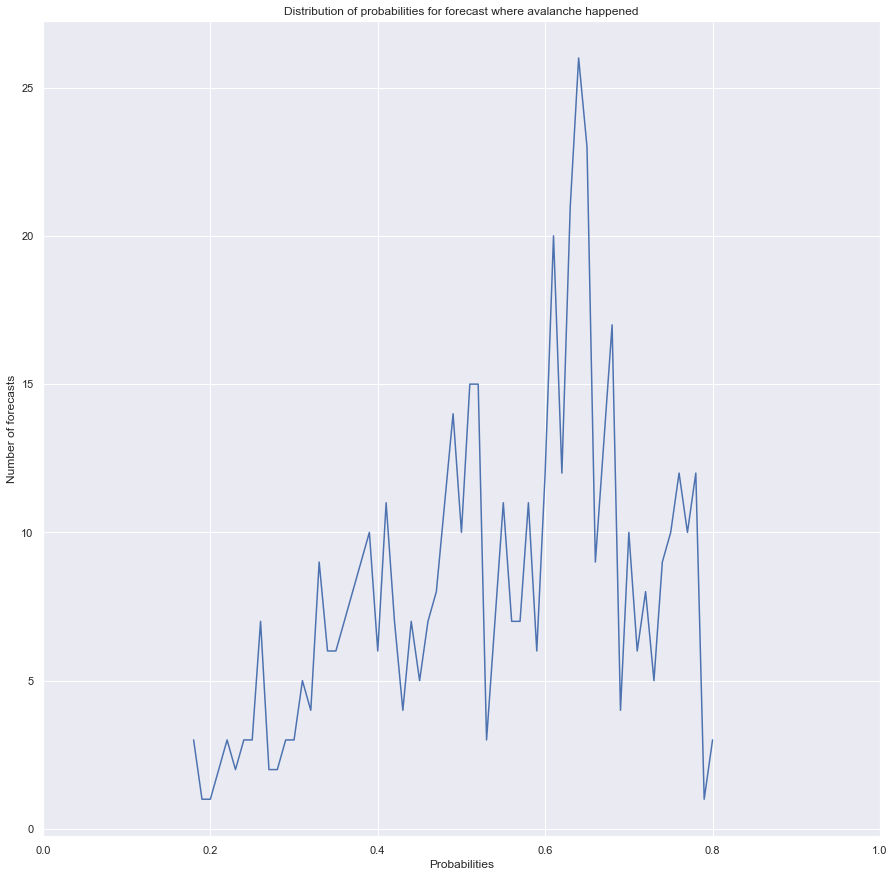

<Figure size 1080x1080 with 0 Axes>

In [26]:
# Plot prediction values for avalanche
prediction_values_for_avalanche = [round(x, 2) for x in prediction_values_for_avalanche]
unique, counts = np.unique(prediction_values_for_avalanche, return_counts=True)

plt.plot(unique, counts)
plt.title("Distribution of probabilities for forecast where avalanche happened")
plt.xlabel("Probabilities")
plt.ylabel("Number of forecasts")
plt.xlim(0, 1)
plt.savefig("plots/probabilities_where_avalanche.png", dpi=300)
plt.show()
plt.clf()

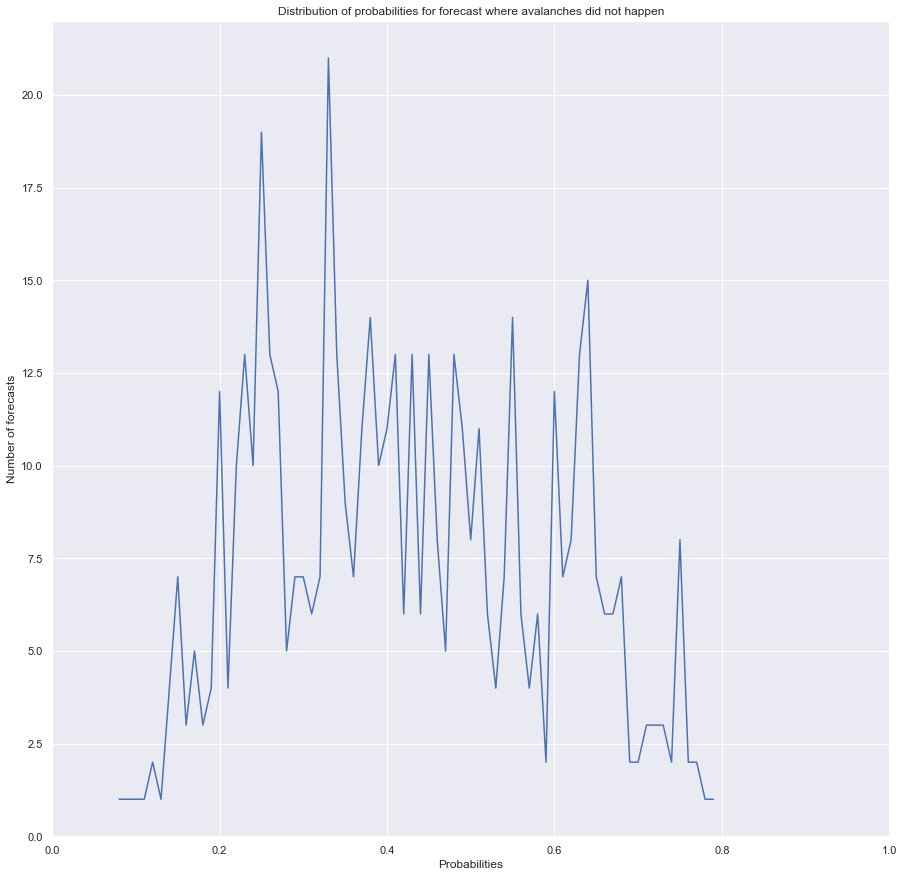

<Figure size 1080x1080 with 0 Axes>

In [27]:
# Plot prediction values for not avalanche
prediction_values_for_not_avalanche = [round(x, 2) for x in prediction_values_for_not_avalanche]
unique, counts = np.unique(prediction_values_for_not_avalanche, return_counts=True)


plt.plot(unique, counts)
plt.title("Distribution of probabilities for forecast where avalanches did not happen")
plt.xlabel("Probabilities")
plt.ylabel("Number of forecasts")
plt.xlim(0, 1)
plt.savefig("plots/probabilities_where_not_avalanche.png", dpi=300)
plt.show()
plt.clf()

# Conclusions
## Results
The results were not as good as we hoped for, and the model gives different results each time we create it. This is seen very clearly on the map plots (showing the results of the model on mock data relative to each region). Create the model again and create a new map plot and you will see the plot changing dramatically, as the model does not seem to find a general global optimum.

We believe some of the reasons why the model does not wok as good as we hoped are:
### We do not have sufficient data
Machine learning in general is very data heavy, and currently we are only using data for the last three seasons. For training we have 518 examples of dates and regions where there are avalanches and 518 examples of dates and regions where there are no avalanches.
### There are too few correlations in the data
The domain of avalanche prediction is dificult for machine learning as there is in general no clear correlations for when an avalanche will occur. The same weather, date and avalanche prediction data can be seen for many days while only a very few of those days will have an avalanche. It is therefore very dificult for the method to seperate our training examples into places where avalanches will happen and not. A correlation plot is included in the jupyter notebook, where we can see that very few variables corralate with our label-variable "avalanche". Again, since the correlation are not that evident, it might be good to have more data.
### This is **not** a binary classification problem
The method we have used is mostly used for classifying examples into binary categories. It seems that this method doesn't work very well with avalanches since the fact that an avalanche has happened is a combination of bad weather and snow conditions, how many people are present in the mountains and how cautious these people are. If you ask experts whether or not an avalanche will happen tomorrow, they will not have an exact answer, since there are so many uncertain variables involved. (they might believe there are higher or lower risk for avalanches, but they cannot be certain). This means there are no "ground truth" for our classification-data (labels).

This is very different from other classification problems where for example want to classify an image as either being "cat" or "dog". In that case it would always be a ground truth being 100% correct.

We were asked to make a confusion matrix for how good the algorithm performs by checking where we "were right" and where we "were wrong" in our predictions. In our opinion this does not sense, because there are no clear right or wrong (ground-truth). If we predict a 51 % chance of a person-triggered avalanche should happen tomorrow and it does, should this be considered a "right guess"? and should 49% be considered a "wrong guess"?

We were also discussing to categorize our output data into multiple categories, but this doesn't make a lot of sense as the model gives somewhat different value ranges from build to build. (It does not converge to the same minimum each time)
### Balancing
We also made the choice to balance our dataset so that the model would not tend towards predicting "not avalanche", as about 95 % of our training data says "not avalanche". This made the algorithm have a lot of guesses around 50%, which is in most cases far far too high.
# Future work
Since our experiments did not go so well, we have some suggestions regarding taking the project further. Everyone is free to fork this project and try out working with the dataset themselves.
## Use more statistical methods instead
As there are no "ground truth" in our data, is it probably better to use some kind of statistical method taking uncertainties futher into account.
## Try again when there is more data available
In 3 years we will have doubled the amount of data, so maybe it will be possible to get better predictions then?
## Gather data from more sources
It was for example discussed to find the number of regobs-observations for the past 3 days before each person-triggered avalanche an use this as an indicator to where the next avalanches are going to happen.